In [ ]:
pip install transformers[torch] 

In [ ]:
!pip3 install torch==1.2.0+cu92 torchvision==0.4.0+cu92 -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
# from sklearn.datasets import load_digits

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable

In [ ]:
print(torch.__version__)

1.12.1+cu113


In [ ]:
 iris= load_iris()
# digits= load_digits()

In [ ]:
X= iris['data']
Y= iris['target']
names= iris['target_names']
feature_names= iris['feature_names']

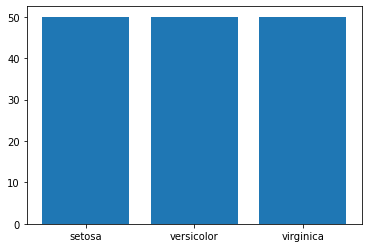

In [ ]:
fig, ax= plt.subplots()
target_names= iris.target_names
counts= np.unique(Y, return_counts=True)[1]
ax.bar(target_names, counts)
plt.show()

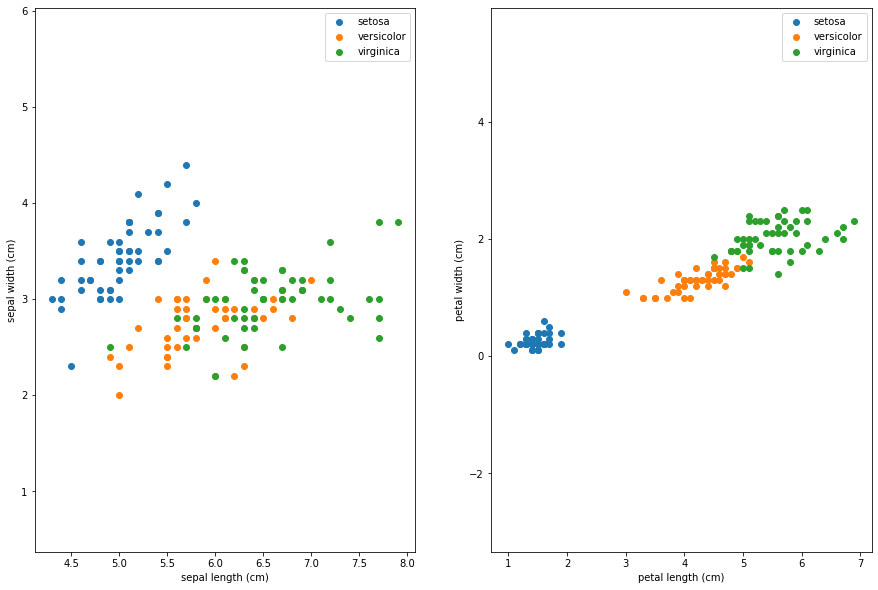

In [ ]:
fig, (ax1, ax2)= plt.subplots(1,2, figsize=(15,10))
for target, target_name in enumerate(names):
  X_plot= X[Y==target]
  ax1.plot(X_plot[:,0], X_plot[:,1], marker='o',linestyle='none',label= target_name)
ax1.set_xlabel(feature_names[0])
ax1.set_ylabel(feature_names[1])
ax1.axis('equal')
ax1.legend();

for target, target_name in enumerate(names):
    X_plot = X[ Y == target]
    ax2.plot(X_plot[:, 2], X_plot[:, 3], 
             linestyle='none', 
             marker='o', 
             label=target_name)
ax2.set_xlabel(feature_names[2])
ax2.set_ylabel(feature_names[3])
ax2.axis('equal')
ax2.legend();


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler= StandardScaler()
X_scaled= scaler.fit_transform(X)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test= train_test_split(X_scaled,Y, test_size=0.34, random_state= 42)


In [ ]:
X_test

array([[ 3.10997534e-01, -5.92373012e-01,  5.35408562e-01,
         8.77547895e-04],
       [-1.73673948e-01,  1.70959465e+00, -1.16971425e+00,
        -1.18381211e+00],
       [ 2.24968346e+00, -1.05276654e+00,  1.78583195e+00,
         1.44883158e+00],
       [ 1.89829664e-01, -3.62176246e-01,  4.21733708e-01,
         3.95774101e-01],
       [ 1.15917263e+00, -5.92373012e-01,  5.92245988e-01,
         2.64141916e-01],
       [-5.37177559e-01,  7.88807586e-01, -1.28338910e+00,
        -1.05217993e+00],
       [-2.94841818e-01, -3.62176246e-01, -8.98031345e-02,
         1.32509732e-01],
       [ 1.28034050e+00,  9.82172869e-02,  7.62758269e-01,
         1.44883158e+00],
       [ 4.32165405e-01, -1.97355361e+00,  4.21733708e-01,
         3.95774101e-01],
       [-5.25060772e-02, -8.22569778e-01,  8.07091462e-02,
         8.77547895e-04],
       [ 7.95669016e-01,  3.28414053e-01,  7.62758269e-01,
         1.05393502e+00],
       [-1.26418478e+00, -1.31979479e-01, -1.34022653e+00,
      

In [ ]:
class NeuralNetwork(nn.Module):
  def __init__(self, input_dim,output_dim):
    super(NeuralNetwork, self).__init__()
    self.layer1= nn.Linear(input_dim,50)
    self.layer2= nn.Linear(50,50)
    self.layer3= nn.Linear(50,output_dim)

  def forward(self, x):
    out = F.relu(self.layer1(x))
    out= F.relu(self.layer2(out))
    out = F.softmax(self.layer3(out), dim= 1)
    return out

In [ ]:
model= NeuralNetwork(X_train.shape[1], 3) 
optimizer= torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn= nn.CrossEntropyLoss()
model

NeuralNetwork(
  (layer1): Linear(in_features=4, out_features=50, bias=True)
  (layer2): Linear(in_features=50, out_features=50, bias=True)
  (layer3): Linear(in_features=50, out_features=3, bias=True)
)

In [ ]:
X_train= torch.FloatTensor(X_train)
X_test= torch.FloatTensor(X_test)
Y_train= torch.LongTensor(Y_train)
Y_test= torch.LongTensor(Y_test)

In [ ]:
import tqdm

EPOCHS= 100 #iterations
'''X_train= Variable(torch.from_numpy(X_train)).float()
Y_train= Variable(torch.from_numpy(Y_train)).long()
X_test= Variable(torch.from_numpy(X_test)).float()
Y_test= Variable(torch.from_numpy(Y_test)).long() '''

loss_list= np.zeros((EPOCHS,)) #train
accuracy_list= np.zeros((EPOCHS,)) #test

for epoch in tqdm.trange(EPOCHS):
  # optimizer.zero_grad()
  y_pred= model(X_train)
  loss= loss_fn(y_pred, Y_train)
  loss_list[epoch]= loss.item()

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  with torch.no_grad():
    y_pred= model(X_test)
    correct= (torch.argmax(y_pred,dim=1)==Y_test).type(torch.FloatTensor)
    accuracy_list[epoch]= correct.mean()



100%|██████████| 100/100 [00:00<00:00, 248.92it/s]


Text(0.5, 0, 'epochs')

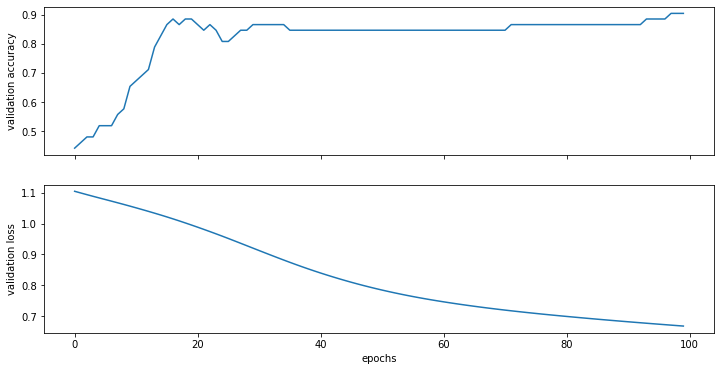

In [ ]:
fig, (ax1,ax2)= plt.subplots(2, figsize=(12,6),sharex=True)
ax1.plot(accuracy_list)
ax1.set_ylabel("validation accuracy")
ax2.plot(loss_list)
ax2.set_ylabel("validation loss")
ax2.set_xlabel("epochs")



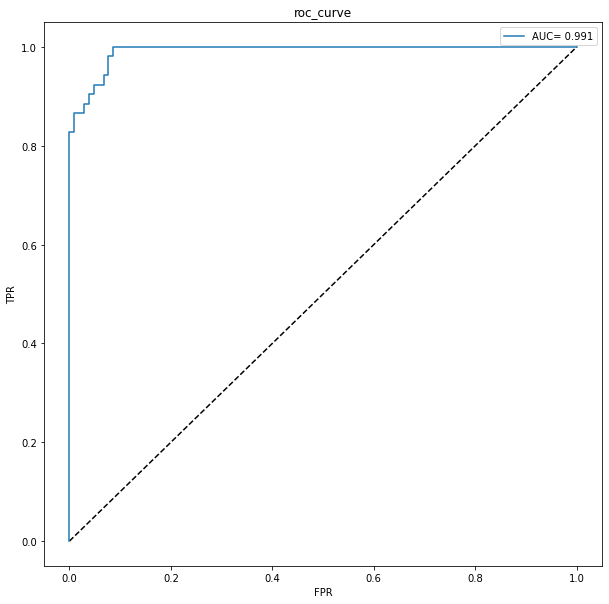

In [ ]:
from sklearn.metrics import roc_curve, auc 
from sklearn.preprocessing import OneHotEncoder

plt.figure(figsize=(10,10))
plt.plot([0,1],[0,1],'k--')

enc= OneHotEncoder()
y_enc= enc.fit_transform(Y_test[:,np.newaxis]).toarray()

with torch.no_grad():
  y_pred= model(X_test).numpy()
  fpr,tpr, threshold= roc_curve(y_enc.ravel(),y_pred.ravel())

plt.plot(fpr, tpr, label='AUC= {:.3f}'.format(auc(fpr,tpr)))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title("roc_curve")
plt.legend()